# （Group) Bayesian Representational Similarity Analysis

This demo shows how to use the Bayesian Representational Similarity Analysis (Bayesian RSA, [Cai et al., 2016](https://proceedings.neurips.cc/paper/2016/hash/b06f50d1f89bd8b2a0fb771c1a69c2b0-Abstract.html),[2019](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006299&rev=2)) with a simulated dataset.

Bayesian RSA builds a generative model for fMRI data which include a covariance structure as estimation target. The covariance structure specifies the distribution by which the unknown spatial neural response patterns for each task condition follow. In the model, the task-evoked pattern, modulated by the design matrix, spontaneous activity and noise together constitute the fMRI data. By marginalizing the intermediate unknow variables including voxel-wise response amplitudes to the task conditions, the model computes a log likelihood for any possible covariance structure of condition-evoked response patterns to generate the fMRI data. It can then directly infer the most likely covariance structure, and convert it to the similarity structure of the neural representation for the task conditions in a region of interest. This is different from the traditional RSA approach which first estimates neural response patterns from data and then treats the noisy estimated patterns as true patterns to calculate their similarity structure. It was shown ([Cai et al., 2016](https://proceedings.neurips.cc/paper/2016/hash/b06f50d1f89bd8b2a0fb771c1a69c2b0-Abstract.html),[2019](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006299&rev=2)) that the traditional approach can introduce bias to the estimated similarity structure and BRSA reduces this bias.

The BrainIAK Bayesian RSA module (brainiak.reprsimil.brsa) includes the following variants of Bayesian RSA:
* (the original) BRSA: a model that estimates representational similarity structure for one subject, and maximal likelihood estimates of SNR and noise parameters for each voxel.
* GBRSA: a model that can either estimate representaitonal similarity structure for one subject, or the shared similarity structure across a group of subjects. It marginalizes voxel-wise SNR and noise parameters and is likely more accurate, but may be slower than BRSA. "G" stands for "Group".

This notebook demonstrates the usage of GBRSA on both single-subject and multiple-subject cases using simulated data. The usage of BRSA method is similar, and readers can refer to this [example](https://github.com/brainiak/brainiak/blob/master/examples/reprsimil/bayesian_rsa_example.ipynb)


## Table of contents
* [Simulate data](#simulate)
* [Fit Group Bayesian RSA to simulated data](#fit)


##### Notes on data preparation
When you apply this tool to real fMRI data, it is required that the data of each participant to be motion corrected. If multiple runs are acquired for each participant, they should be spatially aligned. Slice-timing correction is recommended. 


You will need to have the mask of the Region of Interest (ROI) ready (defined anatomically or by independent tasks, which is up to you). nilearn provides tools to extract signal from mask. You can refer to this [tutorial](http://nilearn.github.io/manipulating_images/manipulating_images.html)

##### Notes on model assumption
Please note that the model assumes that the covariance matrix U which all $\beta_i$ follow describe a multi-variate Gaussian distribution that is zero-meaned. This assumption does not imply that there must be both positive and negative responses across voxels.
However, it means that (Group) Bayesian RSA treats the task-evoked activity against baseline BOLD level as signal, while in other RSA tools the deviation of task-evoked activity in each voxel from the average task-evoked activity level across voxels may be considered as signal of interest.
Due to this assumption in (G)BRSA, relatively high degree of similarity may be expected when the activity patterns of two task conditions share a strong sensory driven components. When two task conditions elicit exactly the same activity pattern but only differ in their global magnitudes, under the assumption in (G)BRSA, their similarity is 1; under the assumption that only deviation of pattern from average patterns is signal of interest (which is currently not supported by (G)BRSA), their similarity would be -1 because the deviations of the two patterns from their average pattern are exactly opposite.

#### Load some package which we will use in this demo.
If you see error related to loading any package, you can install that package. For example, if you use Anaconda, you can use "conda install matplotlib" to install matplotlib.

In [1]:
%matplotlib inline
import scipy.stats
import scipy.spatial.distance as spdist
import numpy as np
from brainiak.reprsimil.brsa import GBRSA
import brainiak.utils.utils as utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
np.random.seed(10)
import copy

You might want to keep a log of the output.

In [2]:
logging.basicConfig(
    level=logging.DEBUG,
    filename='gbrsa_example.log',
    format='%(relativeCreated)6d %(threadName)s %(message)s')

## Simulate data <a class="anchor" id="simulate"></a>
We want to simulate some data in which each voxel responds to different task conditions differently, but following a common covariance structure

#### Load an example design matrix.
To use BRSA, you need to prepare design matrix for the task with your favorate software, such as using 3ddeconvolve of AFNI, or using SPM or FSL.

The design matrix reflects your belief of how fMRI signal should respond to a task (if a voxel does respond).
The common assumption is that a neural event that you are interested in will elicit a slow hemodynamic response in some voxels. The response peaks around 4-6 seconds after the event onset and dissipatess ~12 seconds after the event. Therefore, typically you convolve a time series A, composed of delta (stem) functions reflecting the time of each neural event belonging to the same category (e.g. all trials in which a participant sees a face), with a hemodynamic response function B, to form the hypothetic response of any voxel to such type of neural event.
For each type of event, one convoluted time course can be generated this wat. The time courses corresponding to all events, put together, are called design matrix.
Our goal is to figure out how the (spatial) response pattern of a population of voxels (in an Region of Interest, ROI) are similar or disimilar to different types of tasks (e.g., watching face vs. house, watching different categories of animals, different conditions of a cognitive task). So we need the design matrix in order to estimate the similarity matrix we are interested.

We can use the utility called ReadDesign from brainiak.utils to read a design matrix generated from AFNI. For design matrix saved as Matlab data file by SPM or or other toolbox, you can use scipy.io.loadmat('YOURFILENAME') and extract the design matrix from the dictionary returned. Basically, (G)BRSA just needs a numpy array which is in size of {time points} * {condition}
You can also generate design matrix using the function gen_design in brainiak.utils. It takes in (names of) event timing files in AFNI or FSL format (denoting onsets, duration, and weight for each event belongning to the same condition) and outputs the design matrix as numpy array.

In typical fMRI analysis, some nuisance regressors such as head motion, baseline time series and slow drift are also entered into regression. In using (G)BRSA, you should not include such regressors into the design matrix, because the spatial spread of such nuisance regressors might be quite different from the spatial spread of task related signal. Including such nuisance regressors in design matrix might influence the pseudo-SNR map, which in turn influence the estimation of the shared covariance matrix. But you may include motion time course in the nuisance parameter.

In this simulation, we repeat the design matrix by 2 to 3 times, mimicking 2 to 3 runs of identical timing
Note that different subjects do not have to have the same number of voxels or time points. The timing of the task conditions of them can also differ. The simulation below reflects this.


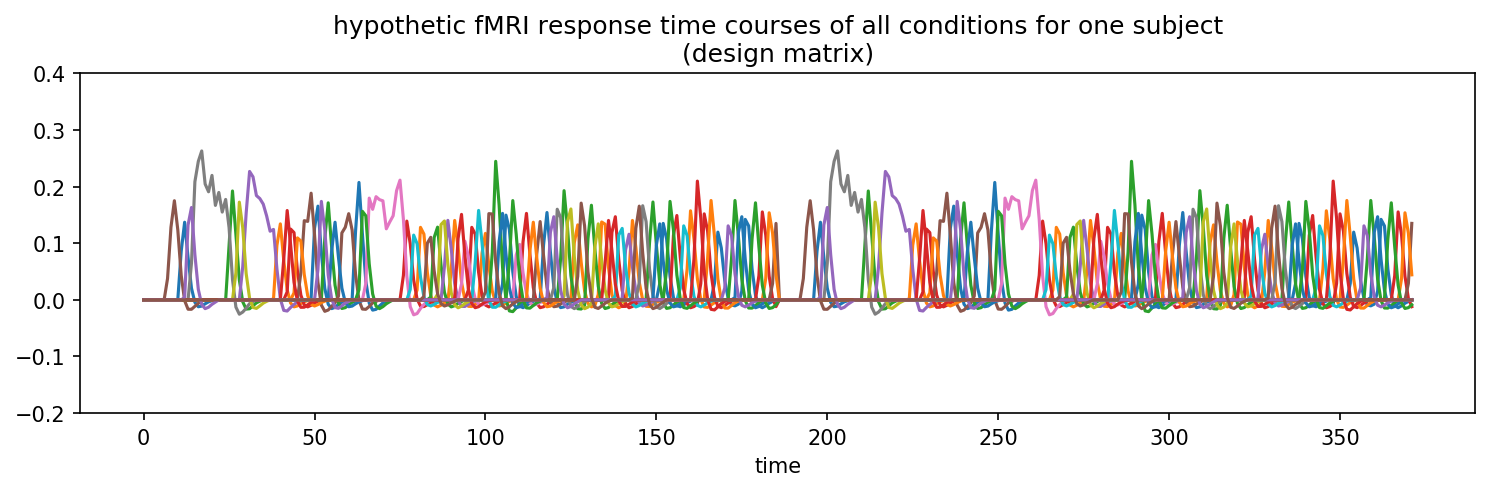

In [18]:
n_subj = 5
n_run = np.random.randint(2, 4, n_subj)
ROI_edge = np.random.randint(20, 40, n_subj)
# We simulate "ROIs" of a square shape
design = [None] * n_subj
for subj in range(n_subj):
    design[subj] = utils.ReadDesign(fname="example_design.1D")
    design[subj].n_TR = design[subj].n_TR * n_run[subj]
    design[subj].design_task = np.tile(design[subj].design_task[:,:-1],
                                 [n_run[subj], 1])
    # The last "condition" in design matrix
    # codes for trials subjects made an error.
    # We ignore it here.
n_C = np.size(design[0].design_task, axis=1)
# The total number of conditions.
n_V = [int(roi_e**2) for roi_e in ROI_edge]
# The total number of simulated voxels
n_T = [d.n_TR for d in design]
# The total number of time points,
# after concatenating all fMRI runs
fig = plt.figure(num=None, figsize=(12, 3),
                 dpi=150, facecolor='w', edgecolor='k')
plt.plot(design[0].design_task)
plt.ylim([-0.2, 0.4])
plt.title('hypothetic fMRI response time courses '
          'of all conditions for one subject\n'
         '(design matrix)')
plt.xlabel('time')
plt.show()

#### simulate noise
We simulate noise which is Gaussian Process in space and AR(1) in time

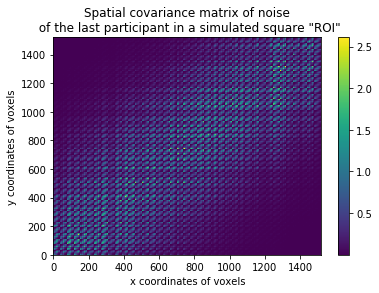

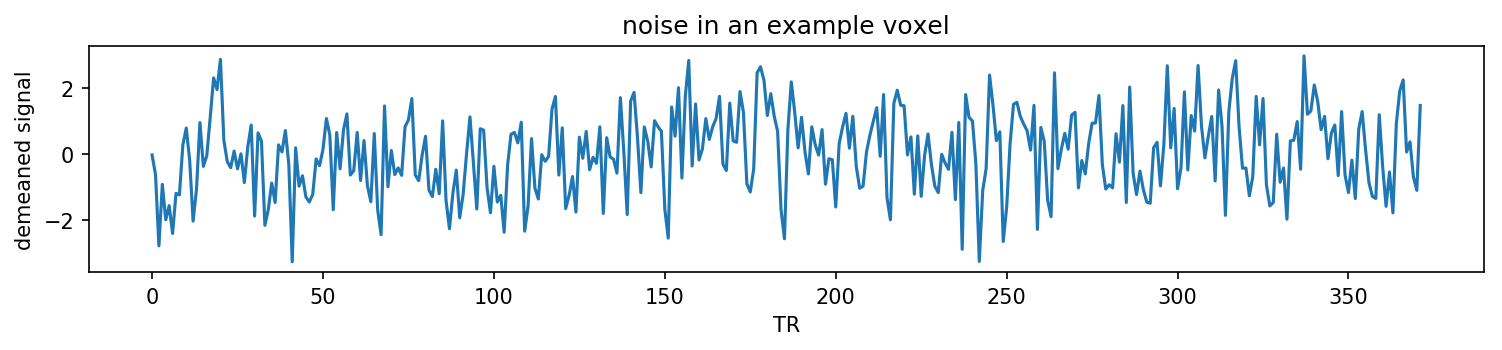

In [68]:
noise_bot = 0.5
noise_top = 1.5
noise_level = [None] * n_subj
noise = [None] * n_subj
rho1 = [None] * n_subj
white_noise_magnitude = 0.4
for subj in range(n_subj):
    # each subject may have different noise level
    noise_level[subj] = np.random.rand(n_V[subj]) * \
        (noise_top - noise_bot) + noise_bot
    # The standard deviation of the noise is in the range of [noise_bot, noise_top]
    # In fact, we simulate autocorrelated noise with AR(1) model. So the noise_level reflects
    # the independent additive noise at each time point (the "fresh" noise)

# AR(1) coefficient
rho1_top = 0.8
rho1_bot = -0.1
for subj in range(n_subj):
    rho1[subj] = np.random.rand(n_V[subj]) \
        * (rho1_top - rho1_bot) + rho1_bot

noise_smooth_width = 10.0
dist2 = [None] * n_subj
for subj in range(n_subj):
    coords = np.mgrid[0:ROI_edge[subj], 0:ROI_edge[subj], 0:1]
    coords_flat = np.reshape(coords,[3, n_V[subj]]).T
    dist2[subj] = spdist.squareform(spdist.pdist(coords_flat, 'sqeuclidean'))

    # generating noise
    K_noise = noise_level[subj][:, np.newaxis] \
        * (np.exp(-dist2[subj] / noise_smooth_width**2 / 2.0) \
           + np.eye(n_V[subj]) * white_noise_magnitude ** 2) * noise_level[subj]
    # We make spatially correlated noise by generating
    # noise at each time point from a Gaussian Process
    # defined over the coordinates.
    L_noise = np.linalg.cholesky(K_noise)
    noise[subj] = np.zeros([n_T[subj], n_V[subj]])
    noise[subj][0, :] = np.dot(L_noise, np.random.randn(n_V[subj]))\
        / np.sqrt(1 - rho1[subj]**2)
    for i_t in range(1, n_T[subj]):
        noise[subj][i_t, :] = noise[subj][i_t - 1, :] * rho1[subj] \
            + np.dot(L_noise,np.random.randn(n_V[subj]))
    # For each voxel, the noise follows AR(1) process:
    # fresh noise plus a dampened version of noise at
    # the previous time point.
    # In this simulation, we also introduced spatial smoothness resembling a Gaussian Process.
    # Notice that we simulated in this way only to introduce spatial noise correlation.
    # Gaussian Process is not the assumption of the form of spatial noise correlation in the model.
    noise[subj] += np.random.randn()
plt.pcolor(K_noise)
plt.colorbar()
plt.xlim([0, ROI_edge[-1] * ROI_edge[-1]])
plt.ylim([0, ROI_edge[-1] * ROI_edge[-1]])
plt.title('Spatial covariance matrix of noise\n of the last participant in a simulated square "ROI"')
plt.xlabel('x coordinates of voxels')
plt.ylabel('y coordinates of voxels')
plt.show()

fig = plt.figure(num=None, figsize=(12, 2), dpi=150,
                 facecolor='w', edgecolor='k')
plt.plot(noise[-1][:, 0])
plt.title('noise in an example voxel')
plt.xlabel('TR')
plt.ylabel('demeaned signal')
plt.show()

#### specify simulated similarity matrix
We assume the magnitude of response to each condition follows a common covariance matrix. 

Let's keep in mind of the pattern of the ideal covariance / correlation below and see how well BRSA can recover their patterns.

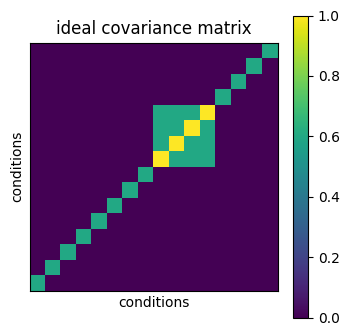

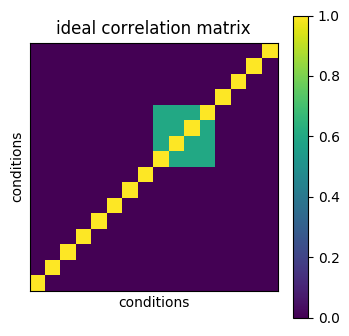

In [69]:
# ideal covariance matrix
ideal_cov = np.zeros([n_C, n_C])
ideal_cov = np.eye(n_C) * 0.6
ideal_cov[8:12, 8:12] = 0.6
for cond in range(8, 12):
    ideal_cov[cond,cond] = 1

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(ideal_cov)
plt.colorbar()
plt.xlim([0, 16])
plt.ylim([0, 16])
ax = plt.gca()
ax.set_aspect(1)
plt.title('ideal covariance matrix')
plt.xlabel('conditions')
plt.ylabel('conditions')
plt.xticks([])
plt.yticks([])
plt.show()

std_diag = np.diag(ideal_cov)**0.5
ideal_corr = ideal_cov / std_diag / std_diag[:, None]
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(ideal_corr)
plt.colorbar()
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_aspect(1)
plt.xlabel('conditions')
plt.ylabel('conditions')
plt.title('ideal correlation matrix')
plt.show()

#### Simulate task-related signals
In the following, pseudo-SNR is generated from a Gaussian Process defined on a "square" ROI, just for simplicity of code. 


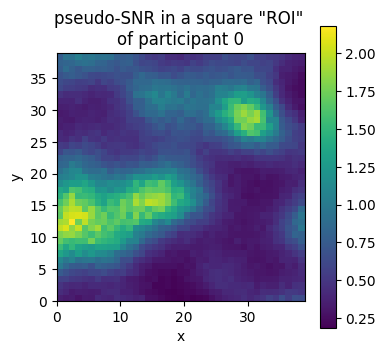

In [70]:
L_full = np.linalg.cholesky(ideal_cov)        

# generating signal
snr_level = np.random.rand(n_subj) * 0.6 + 0.4
# Notice that accurately speaking this is not SNR.
# The magnitude of signal depends not only on beta but also on x.
# (noise_level*snr_level)**2 is the factor multiplied
# with ideal_cov to form the covariance matrix from which
# the response amplitudes (beta) of a voxel are drawn from.

tau = np.random.rand(n_subj) * 0.8 + 0.2
# magnitude of Gaussian Process from which the log(SNR) is drawn
smooth_width = np.random.rand(n_subj) * 5.0 + 3.0
# spatial length scale of the Gaussian Process, unit: voxel



snr = [None] * n_subj
signal = [None] * n_subj
betas_simulated = [None] * n_subj

for subj in range(n_subj):

    K = np.exp(-dist2[subj] / smooth_width[subj]**2 / 2.0) * tau[subj]**2 \
        + np.eye(n_V[subj]) * tau[subj]**2 * 0.01
    # K is the spatial covariance of SNR.
    # A tiny amount is added to the diagonal of
    # the GP covariance matrix to make sure it can be inverted
    L = np.linalg.cholesky(K)
    snr[subj] = np.exp(np.dot(L, np.random.randn(n_V[subj]))) * snr_level[subj]
    sqrt_v = noise_level[subj] * snr[subj]
    betas_simulated[subj] = np.dot(L_full, np.random.randn(n_C, n_V[subj])) * sqrt_v
    # Simulated activation pattern (beta)
    signal[subj] = np.dot(design[subj].design_task, betas_simulated[subj])


fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(np.reshape(snr[0], [ROI_edge[0], ROI_edge[0]]))
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('pseudo-SNR in a square "ROI" \nof participant 0')
plt.xlabel('x')
plt.ylabel('y')
plt.show()    


#### Synthesize data by adding signal with noise

In [71]:
Y = [None] * n_subj
for subj in range(n_subj):
    Y[subj] = signal[subj] + noise[subj]
    # The data to be fed to the program.
    


Now we take a look at the voxels with the lowest SNR and highest SNR for the participant with median level of overall SNR

The reason that the pseudo-SNRs in the example voxels are not too small, while the signal looks much smaller is because we happen to have low amplitudes in our design matrix. The true SNR depends on both the amplitudes in design matrix and the pseudo-SNR. Therefore, be aware that pseudo-SNR does not directly reflects how much signal the data have, but rather a map indicating the relative strength of signal in differerent voxels.

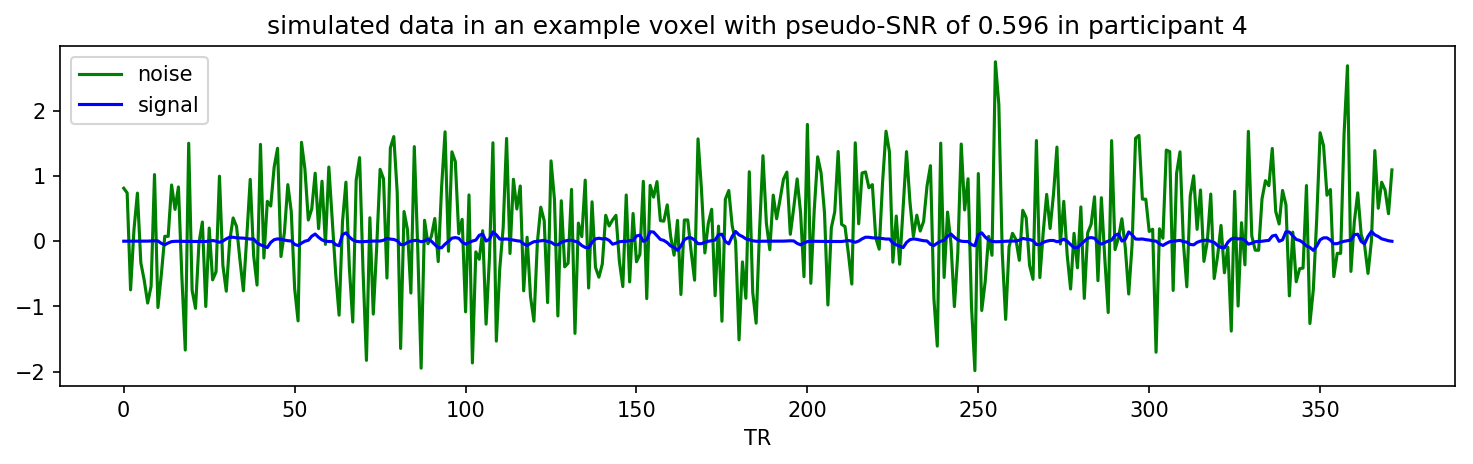

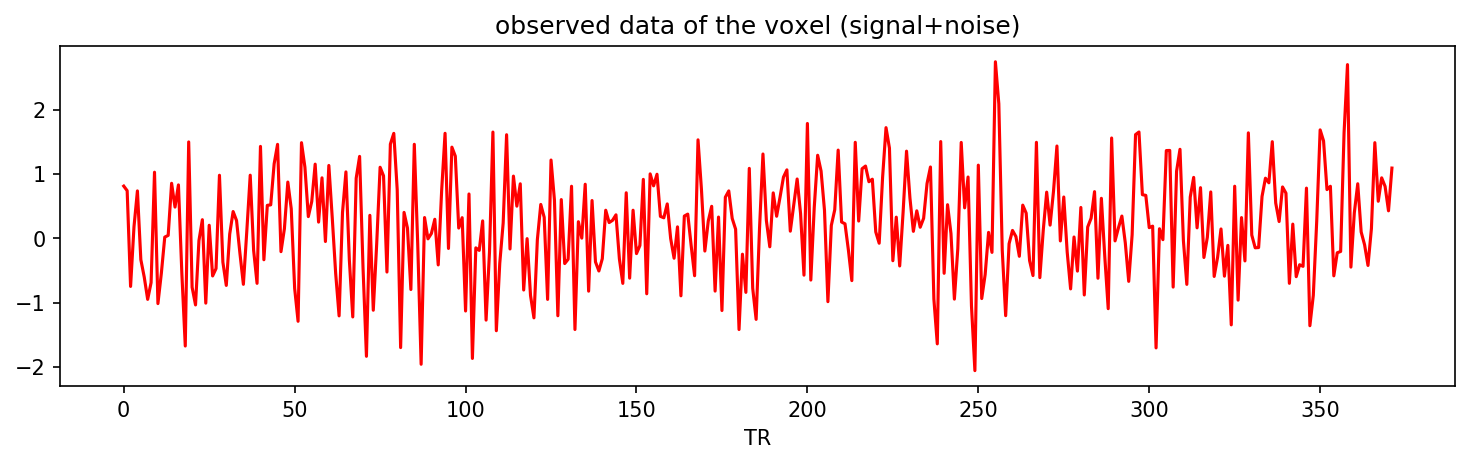

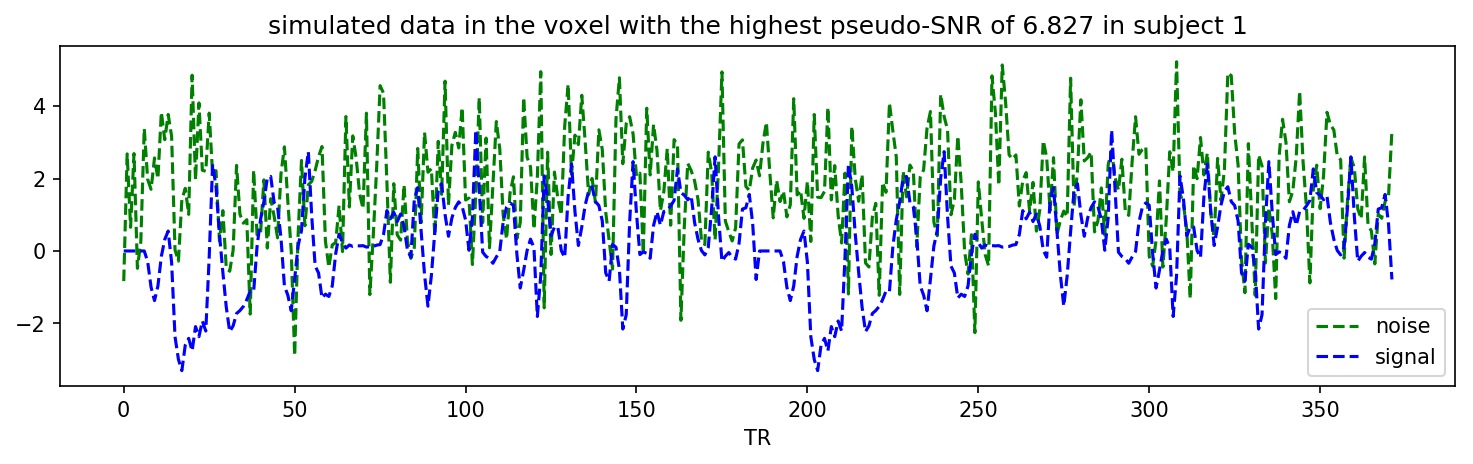

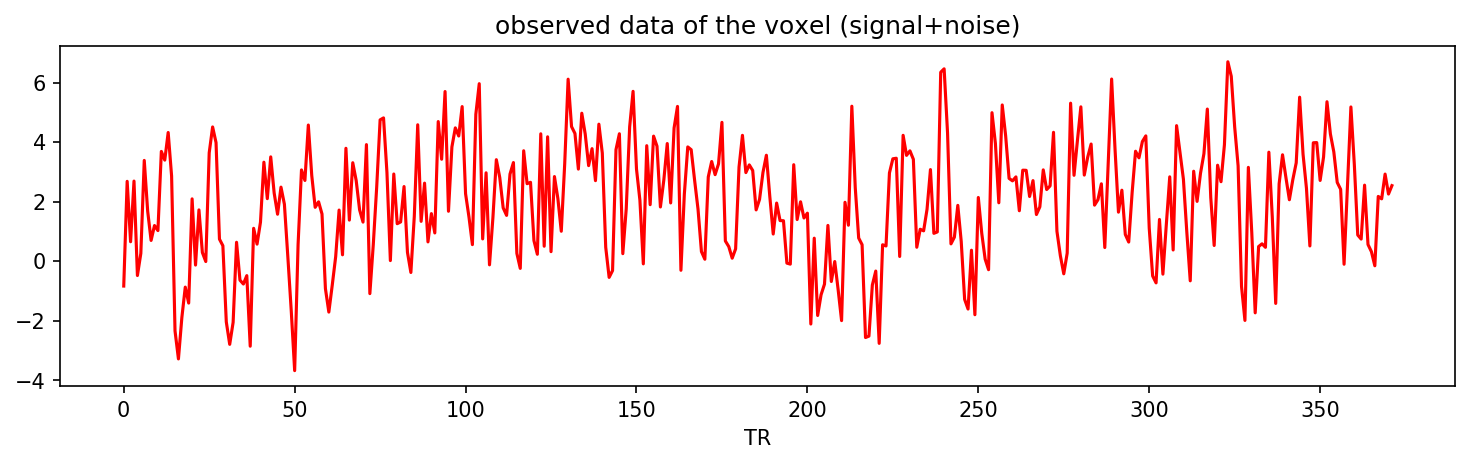

In [79]:
snr_all = np.concatenate(snr)
idx = np.argmin(np.abs(snr_all - np.median(snr_all)))
median_subj = np.min(np.where(idx - np.cumsum(n_V) < 0))

idx = idx - np.cumsum(np.concatenate([[0], n_V]))[median_subj]
# choose a voxel of medium level SNR.
fig = plt.figure(num=None, figsize=(12, 3), dpi=150,
                 facecolor='w', edgecolor='k')
noise_plot, = plt.plot(noise[median_subj][:,idx],'g')
signal_plot, = plt.plot(signal[median_subj][:,idx],'b')
plt.legend([noise_plot, signal_plot], ['noise', 'signal'])
plt.title('simulated data in an example voxel'
          ' with pseudo-SNR of {:.3f} in participant {}'.format(snr[median_subj][idx], median_subj))
plt.xlabel('TR')
plt.show()

fig = plt.figure(num=None, figsize=(12, 3), dpi=150,
                 facecolor='w', edgecolor='k')
data_plot, = plt.plot(Y[median_subj][:,idx],'r')
plt.title('observed data of the voxel (signal+noise)')
plt.xlabel('TR')
plt.show()

idx = np.argmin(np.abs(snr_all - np.max(snr_all)))
highest_subj = np.min(np.where(idx - np.cumsum(n_V) < 0))
idx = idx - np.cumsum(np.concatenate([[0], n_V]))[highest_subj]
# display the voxel of the highest level SNR.
fig = plt.figure(num=None, figsize=(12, 3), dpi=150,
                 facecolor='w', edgecolor='k')
noise_plot, = plt.plot(noise[highest_subj][:,idx],'g--')
signal_plot, = plt.plot(signal[highest_subj][:,idx],'b--')
plt.legend([noise_plot, signal_plot], ['noise', 'signal'])
plt.title('simulated data in the voxel with the highest'
          ' pseudo-SNR of {:.3f} in subject {}'.format(snr[highest_subj][idx], highest_subj))
plt.xlabel('TR')
plt.show()

fig = plt.figure(num=None, figsize=(12, 3), dpi=150,
                 facecolor='w', edgecolor='k')
data_plot, = plt.plot(Y[highest_subj][:,idx],'r')
plt.title('observed data of the voxel (signal+noise)')
plt.xlabel('TR')
plt.show()

# Fit Group Bayesian RSA to simulated data <a class="anchor" id="fit"></a>


In BRSA and GBRSA, the nuisance regressors in typical fMRI analysis (such as head motion signal) are replaced by principal components estimated from residuals after subtracting task-related response. `n_nureg` tells the model how many principal components to keep from the residual as nuisance regressors, in order to account for spatial correlation in noise. When it is set to None and `auto_nuisance=True`, this number will be estimated automatically by an algorithm of [Gavish & Dohono 2014](https://ieeexplore.ieee.org/document/6846297). If you prefer not using this approach based on principal components of residuals, you can set `auto_nuisance=False`, and optionally provide your own nuisance regressors as a list (one numpy array per subject) as nuisance argument to `GBRSA.fit()`. In practice, we find that the result is much better with `auto_nuisance=True`.

Apparently one can imagine that the choice of the number of principal components used as nuisance regressors can influence the result. If you just choose 1 or 2, perhaps only the global drift would be captured. But including too many nuisance regressors would slow the fitting speed and might have risk of overfitting. Among all the algorithms we have tested with simulation data, the Gavish & Donoho algorithm appears the most robust and the estimate is closest to the true simulated number. But it does have a tendency to under-estimate the number of components, which is one limitation in (G)BRSA module.


#### Prepare onset information for model fitting
When you have multiple runs, the noise won't be correlated between runs. Therefore, you should tell BRSA when is the onset of each scan. 

Note that the data (variable Y above) you feed to BRSA is the concatenation of data from all runs along the time dimension, as a 2-D matrix of time x space

In [73]:
scan_onsets = [np.int32(np.linspace(0, design[i].n_TR,num=n_run[i] + 1)[: -1]) for i in range(n_subj)]
print('scan onsets: {}'.format(scan_onsets))

scan onsets: [array([  0, 186], dtype=int32), array([  0, 186], dtype=int32), array([  0, 186], dtype=int32), array([  0, 186, 372], dtype=int32), array([  0, 186], dtype=int32)]


#### Instantiate a GBRSA object
To reduce the running time at a cost of inaccuracy, you may specify `SNR_prior='equal'` and a smaller `rho_bins` parameter, as the code commented out below

In [74]:
gbrsa = GBRSA()

# gbrsa = GBRSA(SNR_prior='equal', rho_bins=11)


#### Fit model to the data

In [75]:

gbrsa.fit(X=Y, design=[d.design_task for d in design],scan_onsets=scan_onsets)
# The data to fit should be given to the argument X.
# Design matrix goes to design. And so on.


/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

GBRSA(SNR_bins=21, SNR_prior='exp', anneal_speed=10, auto_nuisance=True,
   baseline_single=False, logS_range=1.0,
   minimize_options={'gtol': 0.0001, 'disp': False, 'maxiter': 20},
   n_iter=100, n_nureg=None,
   nureg_method=<function GBRSA.__init__.<locals>.<lambda> at 0x7f3593637400>,
   nureg_zscore=True, optimizer='L-BFGS-B', random_state=None, rank=None,
   rho_bins=20, tol=0.0001)

# Evaluation

#### Result of GBRSA
We can have a look at the estimated similarity in matrix `gbrsa.C_`. 

We can also compare the ideal covariance above with the one recovered, `gbrsa.U_`

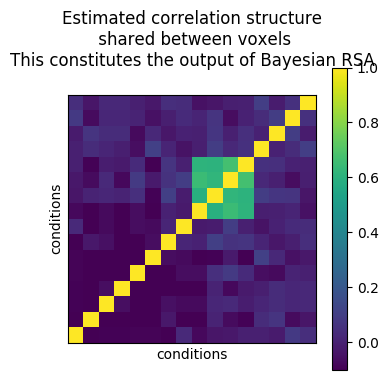

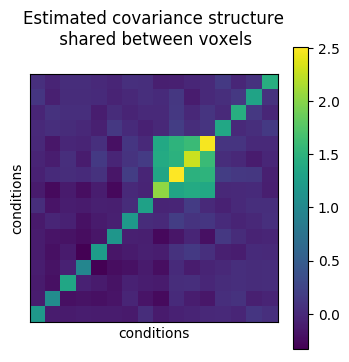

In [80]:
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(gbrsa.C_, vmin=-0.1, vmax=1)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Estimated correlation structure\n shared between voxels\n'
         'This constitutes the output of Bayesian RSA\n')
plt.xlabel('conditions')
plt.ylabel('conditions')
plt.xticks([])
plt.yticks([])
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(gbrsa.U_)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Estimated covariance structure\n shared between voxels\n')
plt.xlabel('conditions')
plt.ylabel('conditions')
plt.xticks([])
plt.yticks([])
plt.show()

#### Compare with result of traditional RSA

In this approach, estimated activation patterns of each task condition ($\beta$) are obtained by regressing data against design matrix.
And then Pearson correlation or other (dis)similarity metric is calculated between the noisy estimates of $\beta$s of different conditions.

/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


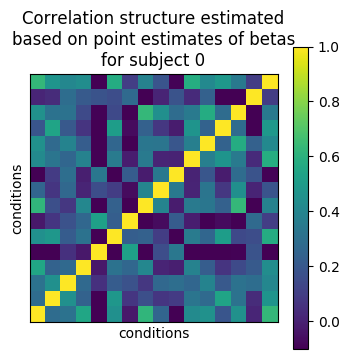

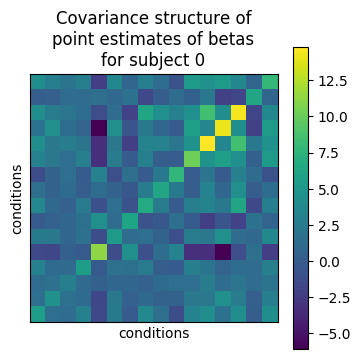

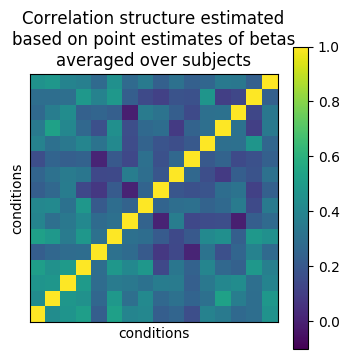

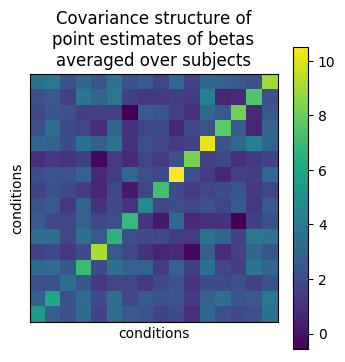

In [77]:
sum_point_corr = np.zeros((n_C, n_C))
sum_point_cov = np.zeros((n_C, n_C))
betas_point = [None] * n_subj
for subj in range(n_subj):
    regressor = np.insert(design[subj].design_task,
                          0, 1, axis=1)
    betas_point[subj] = np.linalg.lstsq(regressor, Y[subj])[0]
    point_corr = np.corrcoef(betas_point[subj][1:, :])
    point_cov = np.cov(betas_point[subj][1:, :])
    sum_point_corr += point_corr
    sum_point_cov += point_cov
    if subj == 0:
        fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
        plt.pcolor(point_corr, vmin=-0.1, vmax=1)
        plt.xlim([0, 16])
        plt.ylim([0, 16])
        plt.colorbar()
        ax = plt.gca()
        ax.set_aspect(1)
        plt.title('Correlation structure estimated\n'
                 'based on point estimates of betas\n'
                 'for subject {}'.format(subj))
        plt.xlabel('conditions')
        plt.ylabel('conditions')
        plt.xticks([])
        plt.yticks([])
        plt.show()

        fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
        plt.pcolor(point_cov)
        plt.xlim([0, 16])
        plt.ylim([0, 16])
        plt.colorbar()
        ax = plt.gca()
        ax.set_aspect(1)
        plt.title('Covariance structure of\n'
                 'point estimates of betas\n'
                 'for subject {}'.format(subj))
        plt.xlabel('conditions')
        plt.ylabel('conditions')
        plt.xticks([])
        plt.yticks([])
        plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(sum_point_corr / n_subj, vmin=-0.1, vmax=1)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Correlation structure estimated\n'
         'based on point estimates of betas\n'
         'averaged over subjects')
plt.xlabel('conditions')
plt.ylabel('conditions')
plt.xticks([])
plt.yticks([])
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(sum_point_cov / n_subj)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Covariance structure of\n'
         'point estimates of betas\n'
         'averaged over subjects')
plt.xlabel('conditions')
plt.ylabel('conditions')
plt.xticks([])
plt.yticks([])
plt.show()

Calculate the root mean squared error between the estimated similarity and simulated similarity structures

In [82]:
RMS_GBRSA = np.mean((gbrsa.C_ - ideal_corr)**2)**0.5
RMS_RSA = np.mean((point_corr - ideal_corr)**2)**0.5
print('RMS error of group Bayesian RSA: {}'.format(RMS_GBRSA))
print('RMS error of standard RSA: {}'.format(RMS_RSA))

RMS error of group Bayesian RSA: 0.07798243257944784
RMS error of standard RSA: 0.27246709845560435


#### Evaluating estimated pseudo-SNR map against the simulated SNR map
If you have chosen `SNR_prior='equal'`, the estimated pseudo-SNR map will be flat

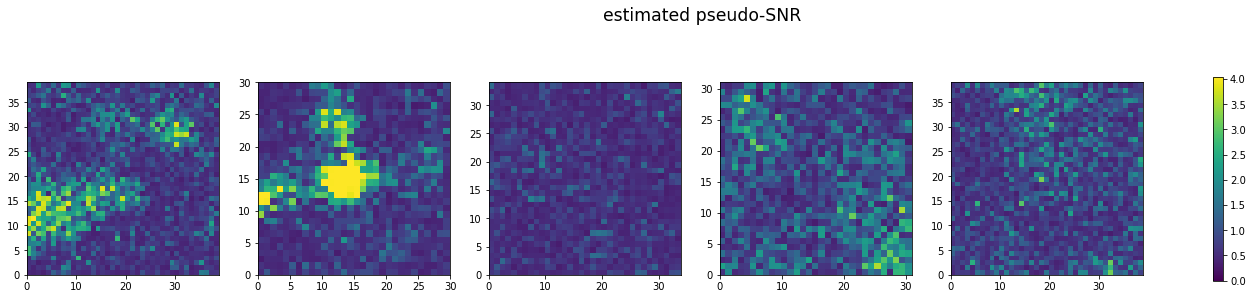

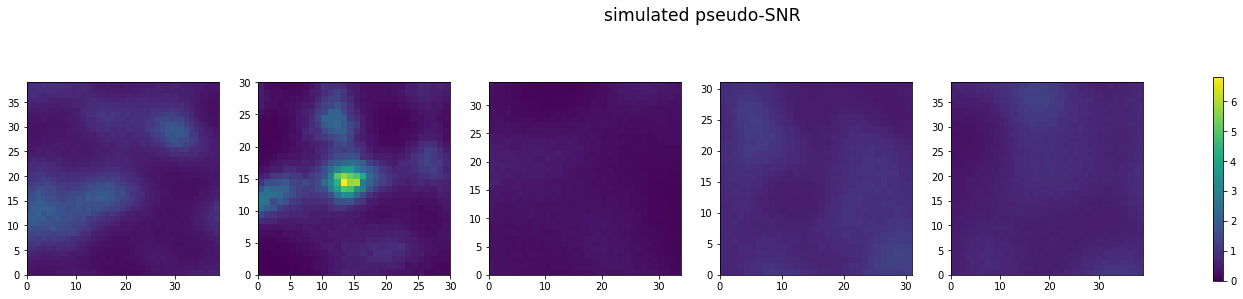

In [81]:
subj = highest_subj


fig, axes = plt.subplots(nrows=1, ncols=n_subj, figsize=(25, 5))


vmax = np.max([np.max(gbrsa.nSNR_[s]) for s in range(n_subj)])
for s in range(n_subj):
    im = axes[s].pcolor(np.reshape(gbrsa.nSNR_[s], [ROI_edge[s], ROI_edge[s]]),
                        vmin=0,vmax=vmax)
    axes[s].set_aspect(1)
    
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75)

plt.suptitle('estimated pseudo-SNR',fontsize="xx-large" )
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=n_subj, figsize=(25, 5))
vmax = np.max([np.max(snr[s]) for s in range(n_subj)])
for s in range(n_subj):
    im = axes[s].pcolor(np.reshape(snr[s], [ROI_edge[s], ROI_edge[s]]),
                        vmin=0,vmax=vmax)
    axes[s].set_aspect(1)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75)
plt.suptitle('simulated pseudo-SNR',fontsize="xx-large" )
plt.show()



#### Examine the recovery of activation pattern
Scatter plot of the recovered $\beta$s and true $\beta$s. Each column is result from one subject.
Top: result by GBRSA. Bottom: result by standard regression analysis

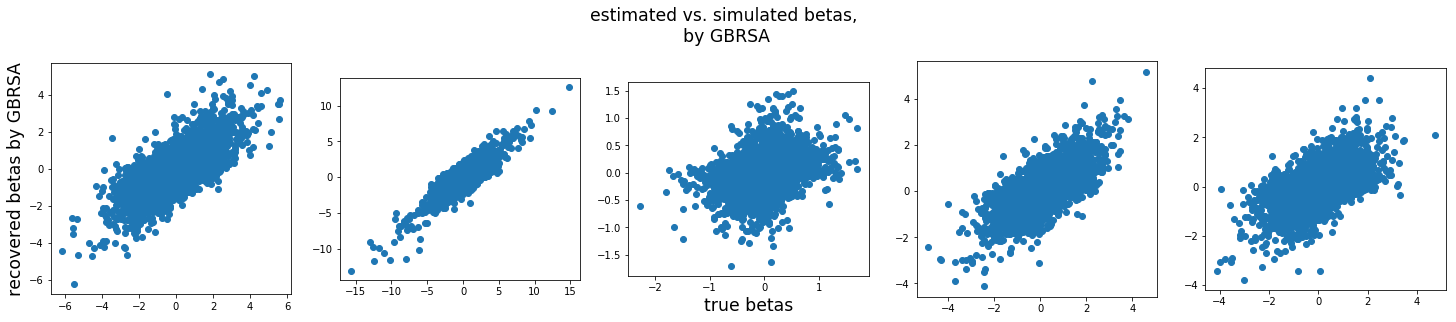

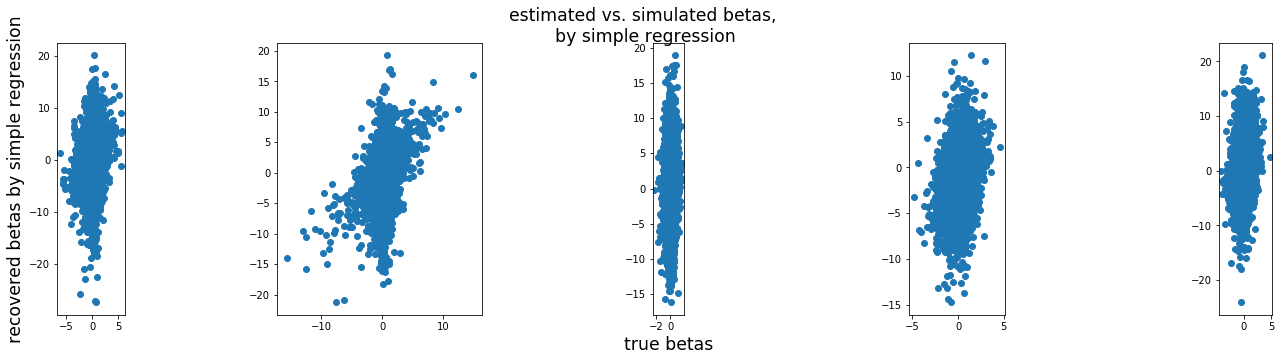

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=n_subj, figsize=(25, 5))
for s in range(n_subj):
    im = axes[s].scatter(betas_simulated[s] , gbrsa.beta_[s])
    if s == 0:
        axes[s].set_ylabel('recovered betas by GBRSA',fontsize='xx-large')
    if s == int(n_subj/2):
        axes[s].set_xlabel('true betas',fontsize='xx-large')
    axes[s].set_aspect(1)
plt.suptitle('estimated vs. simulated betas, \nby GBRSA',fontsize="xx-large" )
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=n_subj, figsize=(25, 5))
for s in range(n_subj):
    im = axes[s].scatter(betas_simulated[s] , betas_point[s][1:, :])
    if s == 0:
        axes[s].set_ylabel('recovered betas by simple regression',fontsize='xx-large')
    if s == int(n_subj/2):
        axes[s].set_xlabel('true betas',fontsize='xx-large')
    axes[s].set_aspect(1)
plt.suptitle('estimated vs. simulated betas, \nby simple regression',fontsize="xx-large" )
plt.show()

# Other usage: "decoding" task-related signal from new data

Now we generate a new data set.
We keep the signal the same as in training data, but generate new noise.

We want to use the transform() function of gbrsa to estimate the "design matrix" in this new dataset.


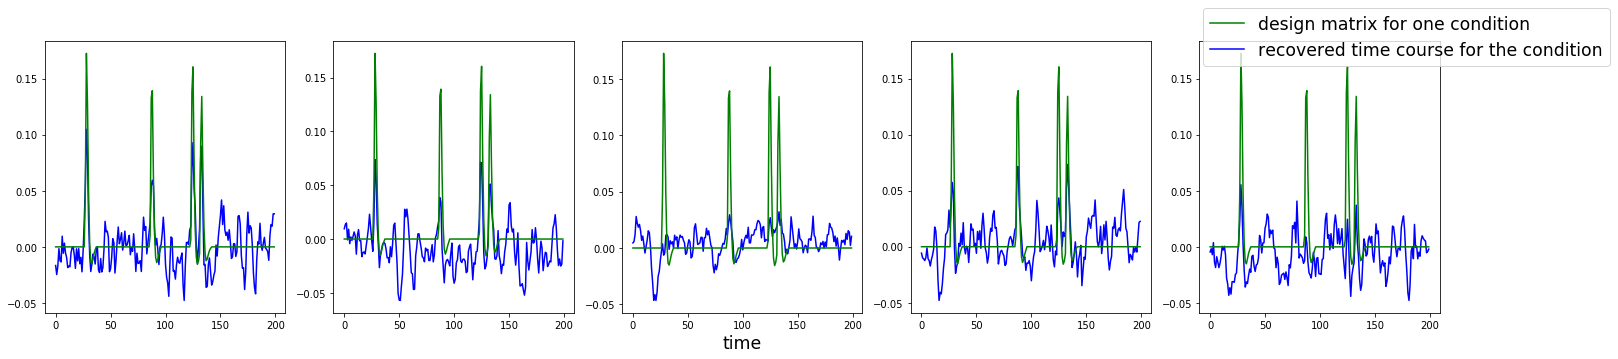

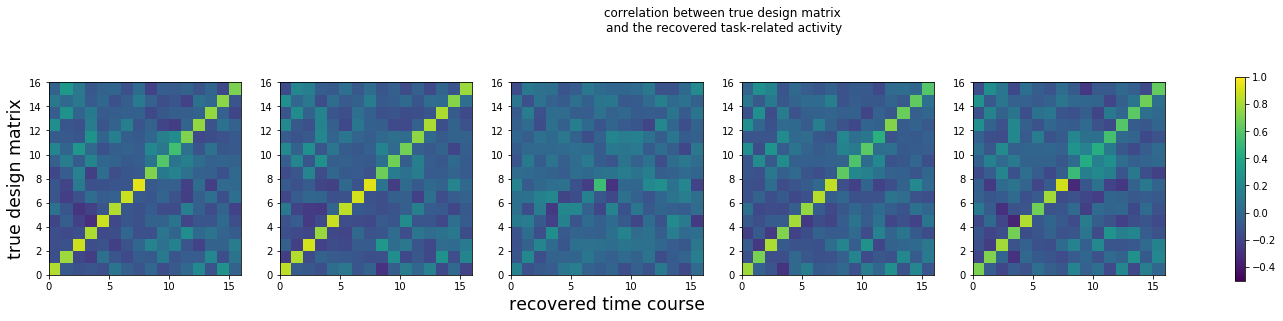

average SNR level: [0.63848305 0.61924873 0.43876294 0.76748045 0.53529492]
Apparently how much the recovered time course resembles the true design matrix depends on SNR


In [86]:
noise_new = [None] * n_subj
Y_new = [None] * n_subj
for subj in range(n_subj):
    
    # generating noise
    K_noise = noise_level[subj][:, np.newaxis] \
        * (np.exp(-dist2[subj] / noise_smooth_width**2 / 2.0) \
           + np.eye(n_V[subj]) * white_noise_magnitude ** 2) * noise_level[subj]
    # We make spatially correlated noise by generating
    # noise at each time point from a Gaussian Process
    # defined over the coordinates.
    L_noise = np.linalg.cholesky(K_noise)
    noise_new[subj] = np.zeros([n_T[subj], n_V[subj]])
    noise_new[subj][0, :] = np.dot(L_noise, np.random.randn(n_V[subj]))\
        / np.sqrt(1 - rho1[subj]**2)
    for i_t in range(1, n_T[subj]):
        noise_new[subj][i_t, :] = noise_new[subj][i_t - 1, :] * rho1[subj] \
            + np.dot(L_noise,np.random.randn(n_V[subj]))
    Y_new[subj] = signal[subj] + noise_new[subj] 



ts, ts0 = gbrsa.transform(Y_new,scan_onsets=scan_onsets)
# ts is the estimated task-related time course, with each column corresponding to the task condition of the same
# column in design matrix.
# ts0 is the estimated time courses that have the same spatial spread as those in the training data (X0).
# It is possible some task related signal is still in X0 or ts0, but not captured by the design matrix.

fig, axes = plt.subplots(nrows=1, ncols=n_subj, figsize=(25, 5))
for s in range(n_subj):
    recovered_plot, = axes[s].plot(ts[s][:200, 8], 'b')
    design_plot, = axes[s].plot(design[s].design_task[:200, 8], 'g')
    if s == int(n_subj/2):
        axes[s].set_xlabel('time',fontsize='xx-large')
    
fig.legend([design_plot, recovered_plot],
           ['design matrix for one condition', 'recovered time course for the condition'],
          fontsize='xx-large')

plt.show()

# We did not plot the whole time series for the purpose of seeing closely how much the two
# time series overlap

fig, axes = plt.subplots(nrows=1, ncols=n_subj, figsize=(25, 5))
for s in range(n_subj):
    c = np.corrcoef(design[s].design_task.T, ts[s].T)
    im = axes[s].pcolor(c[0:16, 16:],vmin=-0.5,vmax=1)
    axes[s].set_aspect(1)
    if s == int(n_subj/2):
        axes[s].set_xlabel('recovered time course',fontsize='xx-large')
    if s == 0:
        axes[s].set_ylabel('true design matrix',fontsize='xx-large')
fig.suptitle('correlation between true design matrix \nand the recovered task-related activity')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75)
plt.show()


print('average SNR level:', snr_level)
print('Apparently how much the recovered time course resembles the true design matrix depends on SNR')

# Model selection by cross-validataion:
Both BRSA and GBRSA can compare full model against a null model (without task-related responses) by cross-validating the parameters of one model learnt from some training data on some testing data. GBRSA provides a score() function, which returns a pair of cross-validated log likelihood for the testing data. 

The first returned item is a numpy array of the cross-validated log likelihood of the model you have specified, for the testing data of all the subjects.
The second is a numpy arrary of those of a null model which assumes everything else the same except that there is no task-related activity.

Notice that comparing the score of your model of interest against its corresponding null model is not the only way to compare models. You might also want to compare against a model using the same set of design matrix, but a different rank (especially rank 1, which means all task conditions have the same response pattern, only differing in their magnitude).

In general, in the context of GBRSA, a model means the timing of each event and the way these events are grouped, together with other trivial parameters such as the rank of the covariance matrix and the number of nuisance regressors. All these parameters can influence model performance.
In future, we may provide interface to evaluate the predictive power for the data by different predefined similarity matrix or covariance matrix.

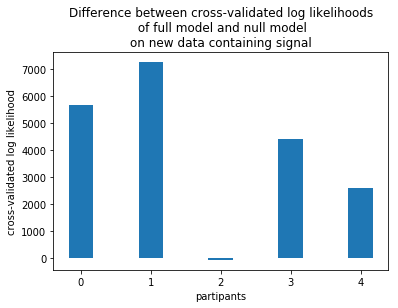

When cross-validating on new data that have the same property of signal and noise with training data., full model should be better than null model


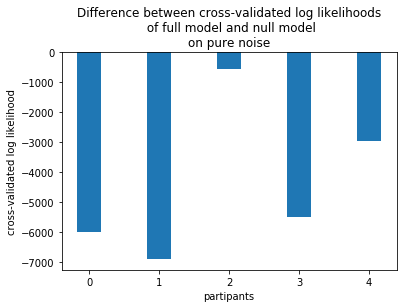

When cross-validating on pure noise, full model should not be better than null model


In [94]:

width = 0.35
[score, score_null] = gbrsa.score(X=Y_new, design=[d.design_task for d in design], scan_onsets=scan_onsets)

plt.bar(np.arange(n_subj),np.asarray(score)-np.asarray(score_null), width=width)
# plt.ylim(0, np.max([np.asarray(score)-np.asarray(score_null)])+100)
plt.ylabel('cross-validated log likelihood')
plt.xlabel('partipants')
plt.title('Difference between cross-validated log likelihoods\n of full model and null model\non new data containing signal')
plt.show()
print('When cross-validating on new data that have the same property of signal and noise with training data., full model should be better than null model')

Y_nosignal = [noise_new[s] for s in range(n_subj)]
[score_noise, score_null_noise] = gbrsa.score(X=Y_nosignal, design=[d.design_task for d in design], scan_onsets=scan_onsets)

plt.bar(np.arange(n_subj),np.asarray(score_noise)-np.asarray(score_null_noise), width=width)
# plt.ylim(np.min([np.asarray(score_noise)-np.asarray(score_null_noise)])-100,
#          0)
plt.ylabel('cross-validated log likelihood')
plt.xlabel('partipants')
plt.title('Difference between cross-validated log likelihoods\n of full model and null model\non pure noise')
plt.show()
print('When cross-validating on pure noise, full model should not be better than null model')

# Avoiding false discovery

If a model is fit to pure noise, some result of similarity structure can still be returned. How do we know if the result is valid?

One approach is to examine the cross-validation score on left-out scans acquired with the same task.

Below, we fit the model to data containing only noise and cross-validate it on another set of noise.

When fitted to noise, the result should be meaningless. Ideally the cross-validated log likelihood of the full model should be smaller than that of the null model.

/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/home/mingbo/anaconda3/envs/has_brainiak/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

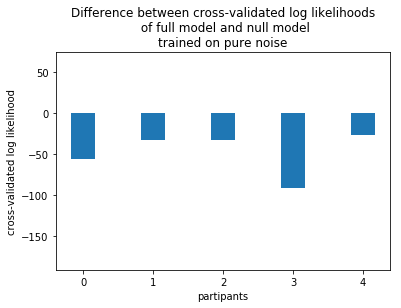

In [96]:
gbrsa_noise = GBRSA(n_iter=40)
gbrsa_noise.fit(X=[noise[s] for s in range(n_subj)],
                design=[d.design_task for d in design],scan_onsets=scan_onsets)
Y_nosignal = [noise_new[s] for s in range(n_subj)]
[score_noise, score_null_noise] = gbrsa_noise.score(X=Y_nosignal,
                                                    design=[d.design_task for d in design], scan_onsets=scan_onsets)

plt.bar(np.arange(n_subj),np.asarray(score_noise)-np.asarray(score_null_noise), width=width)
plt.ylim(np.min([np.asarray(score_noise)-np.asarray(score_null_noise)])-100,
         np.max([np.asarray(score_noise)-np.asarray(score_null_noise)])+100)
plt.ylabel('cross-validated log likelihood')
plt.xlabel('partipants')
plt.title('Difference between cross-validated log likelihoods\n of full model and null model\ntrained on pure noise')
plt.show()

We can see that the difference is smaller but full model generally performs slightly worse, because of overfitting. This is expected.

So, after fitting a model to your data, you should also check cross-validated log likelihood on separate runs from the same group of participants, and make sure your model is at least better than a null model before you trust your similarity matrix. 

Another diagnostic of bad model to your data is very small diagonal values in the shared covariance structure `U_` as shown below:

Text(0.5,1,'covariance matrix of task conditions estimated from pure noise')

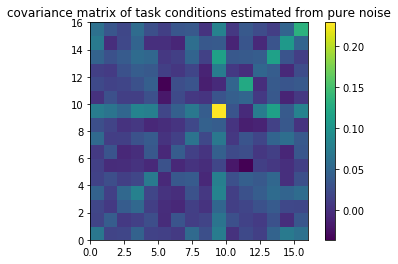

In [97]:
plt.pcolor(gbrsa_noise.U_)
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('covariance matrix of task conditions estimated from pure noise')